# Project Code
#### Joey Livorno | gil15@pitt.edu | 3.16.2020 | EXISTING

The purpose of this project is to process the contents of Donald Trump's Twitter feed and make linguistic and statistical discoveries based on the data, specifically using sentiment analysis. In the second part of the project, we will build a machine learning model that will predict whether or not a tweet was composed by Donald Trump.

These are the required libraries for this assignment:

In [1]:
#import libraries
import numpy as np
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from textblob import TextBlob as tb ##TextBlob object will allow for quick sentiment analysis

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Basic Data Processing

This section of the code will focus on reading in the twitter data and manipulating it into a much more workable object than simply the raw .csv file. In the first section, this will be done for the Trump tweets that I am looking to analyze, and in the second it will be done with that data as well as the .csv file of random US tweets.

### Trump Tweets
The first effort of data processing will go towards creating the dataframe that will contain exclusively Trump tweets.

The first step is to read the .csv file into a pandas dataframe:

In [2]:
#read tweet information into dataframe
tweets = pd.read_csv('../data/tweets.csv')
tweets.head() #preview the df

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,RT @SenBillCassidy: January #JobsReport:✅22500...,02-21-2020 16:06:40,896.0,0.0,True,1.230887e+18
1,Twitter for iPhone,RT @SteveDaines: Obama sure didn’t build this ...,02-21-2020 16:06:20,2086.0,0.0,True,1.230886e+18
2,Twitter for iPhone,RT @JohnBoozman: Our servicemembers stand read...,02-21-2020 16:06:10,521.0,0.0,True,1.230886e+18
3,Twitter for iPhone,RT @RoyBlunt: ▶️ Unemployment is at a nearly 5...,02-21-2020 16:05:52,623.0,0.0,True,1.230886e+18
4,Twitter for iPhone,RT @JimInhofe: Happy 79th birthday to @USCGRes...,02-21-2020 16:05:25,533.0,0.0,True,1.230886e+18


Next we will use the TextBlob library to assign each of the tweets a polarity and subjectivity value. Polarity is on a scale from -1 to 1 and describes how positive or negative the tweet is, -1 being negative and 1 being positive. Subjectivity is on a scale from 0 to 1 and describes whether or not the text is presented as a fact or an opinion. For this measure, 0 would be objective information and 1 would be subjective information.

In [4]:
#create series objects of the polarity and subjectivity of the tweets
polarity = tweets.text.map(lambda x: tb(x).sentiment.polarity)
subjectivity = tweets.text.map(lambda x: tb(x).sentiment.subjectivity)

Then we will create new columns for each of the new series:

In [5]:
#add new columns to tweets df corresponding to the new info
tweets['polarity'] = polarity
tweets['subjectivity'] = subjectivity
tweets.head() #preview the df

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,polarity,subjectivity
0,Twitter for iPhone,RT @SenBillCassidy: January #JobsReport:✅22500...,02-21-2020 16:06:40,896.0,0.0,True,1.230887e+18,0.068182,0.377273
1,Twitter for iPhone,RT @SteveDaines: Obama sure didn’t build this ...,02-21-2020 16:06:20,2086.0,0.0,True,1.230886e+18,0.625000,0.888889
2,Twitter for iPhone,RT @JohnBoozman: Our servicemembers stand read...,02-21-2020 16:06:10,521.0,0.0,True,1.230886e+18,0.200000,0.500000
3,Twitter for iPhone,RT @RoyBlunt: ▶️ Unemployment is at a nearly 5...,02-21-2020 16:05:52,623.0,0.0,True,1.230886e+18,0.100000,0.400000
4,Twitter for iPhone,RT @JimInhofe: Happy 79th birthday to @USCGRes...,02-21-2020 16:05:25,533.0,0.0,True,1.230886e+18,0.750000,0.750000


Since we are going to be looking at change over time, we will need a way to group the tweets chronologically. Luckily, the timestamp is included in the original csv. The most logical grouping seems to be by year though, so let's make a new column that isolates that value:

In [6]:
#make new column that shows year
tweets['created_at'] = pd.to_datetime(tweets['created_at']) #convert created_at column to timestamp data type
tweets['year'] = tweets['created_at'].dt.year.astype('Int64') #store the dates in a new column, isolating the year
tweets.head() #preview df

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,polarity,subjectivity,year
0,Twitter for iPhone,RT @SenBillCassidy: January #JobsReport:✅22500...,2020-02-21 16:06:40,896.0,0.0,True,1.230887e+18,0.068182,0.377273,2020
1,Twitter for iPhone,RT @SteveDaines: Obama sure didn’t build this ...,2020-02-21 16:06:20,2086.0,0.0,True,1.230886e+18,0.625000,0.888889,2020
2,Twitter for iPhone,RT @JohnBoozman: Our servicemembers stand read...,2020-02-21 16:06:10,521.0,0.0,True,1.230886e+18,0.200000,0.500000,2020
3,Twitter for iPhone,RT @RoyBlunt: ▶️ Unemployment is at a nearly 5...,2020-02-21 16:05:52,623.0,0.0,True,1.230886e+18,0.100000,0.400000,2020
4,Twitter for iPhone,RT @JimInhofe: Happy 79th birthday to @USCGRes...,2020-02-21 16:05:25,533.0,0.0,True,1.230886e+18,0.750000,0.750000,2020


Finally, we will add another column that contains the contents of the tweets, but one that is lowercased and tokenized. First, we will define a method that does both of those at once:

In [7]:
#define the. function
def token_lower(s):
    """Returns a tokenized and lowercased copy of the string s"""
    tokens = word_tokenize(s.lower())
    return ' '.join(tokens)

#test the function
print(token_lower('Hey there, how are you?'))

hey there , how are you ?


And then we will add the new column to the dataframe:

In [8]:
tweets['token_lower'] = tweets.text.map(lambda x: token_lower(x))
tweets['token_lower'].head()

0    rt @ senbillcassidy : january # jobsreport : ✅...
1    rt @ stevedaines : obama sure didn ’ t build t...
2    rt @ johnboozman : our servicemembers stand re...
3    rt @ royblunt : ▶️ unemployment is at a nearly...
4    rt @ jiminhofe : happy 79th birthday to @ uscg...
Name: token_lower, dtype: object

Looks good! Now, the data is much more workable; we have the measurements we are looking to compare neatly organized within their corresponding rows, and we have a way of grouping the data chronologically. The last step is to create subgroups for different political issues that we can compare to:

(these are subject to change)

In [9]:
russia_keywords = 'russia|moscow|putin'
iran_keywords = 'iran|tehran|nuclear deal|rouhani'
china_keywords = 'china|beijing|xi|jinping'

In [10]:
#create the subsets for each topic
russia = tweets['token_lower'].str.contains(russia_keywords)
iran = tweets['token_lower'].str.contains(iran_keywords)
china = tweets['token_lower'].str.contains(china_keywords)

#and just for fun
sad = tweets['token_lower'].str.contains('sad')

And we can take a peek as to how much data we've collected in each subset:

In [11]:
tweets[russia].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218 entries, 16 to 15114
Data columns (total 11 columns):
source            218 non-null object
text              218 non-null object
created_at        218 non-null datetime64[ns]
retweet_count     218 non-null float64
favorite_count    218 non-null float64
is_retweet        218 non-null object
id_str            218 non-null float64
polarity          218 non-null float64
subjectivity      218 non-null float64
year              218 non-null Int64
token_lower       218 non-null object
dtypes: Int64(1), datetime64[ns](1), float64(5), object(4)
memory usage: 20.7+ KB


In [12]:
tweets[iran].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 36 to 15251
Data columns (total 11 columns):
source            249 non-null object
text              249 non-null object
created_at        249 non-null datetime64[ns]
retweet_count     249 non-null float64
favorite_count    249 non-null float64
is_retweet        249 non-null object
id_str            249 non-null float64
polarity          249 non-null float64
subjectivity      249 non-null float64
year              249 non-null Int64
token_lower       249 non-null object
dtypes: Int64(1), datetime64[ns](1), float64(5), object(4)
memory usage: 23.6+ KB


In [32]:
tweets[china].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 562 entries, 17 to 15371
Data columns (total 11 columns):
source            562 non-null object
text              562 non-null object
created_at        562 non-null datetime64[ns]
retweet_count     562 non-null float64
favorite_count    562 non-null float64
is_retweet        562 non-null object
id_str            562 non-null float64
polarity          562 non-null float64
subjectivity      562 non-null float64
year              562 non-null Int64
token_lower       562 non-null object
dtypes: Int64(1), datetime64[ns](1), float64(5), object(4)
memory usage: 53.2+ KB


In [14]:
tweets[sad].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 25 to 15242
Data columns (total 11 columns):
source            302 non-null object
text              302 non-null object
created_at        302 non-null datetime64[ns]
retweet_count     302 non-null float64
favorite_count    302 non-null float64
is_retweet        302 non-null object
id_str            302 non-null float64
polarity          302 non-null float64
subjectivity      302 non-null float64
year              302 non-null Int64
token_lower       302 non-null object
dtypes: Int64(1), datetime64[ns](1), float64(5), object(4)
memory usage: 28.6+ KB


And here is the size and shape of the overall dataset:

In [15]:
#print shape
tweets.shape

(15384, 11)

In [16]:
#print size
tweets.size

169224

Finally, I will pickle the dataframe I've made for the ease of reuse:

In [17]:
#save the pickle of the data to 'trump_tweets.pkl' located in the directory 'data'
pd.to_pickle(tweets, '../data/trump_tweets.pkl')

### All Tweets
This section will focus on creating the dataframe that will be used in the Machine Learning section of the project. This data will consist of both tweets composed by Trump and a general collection of US tweets that I downloaded for free from [this website](http://followthehashtag.com/datasets/free-twitter-dataset-usa-200000-free-usa-tweets/). The website does not specify any licenses and is made for student research such as this, so I have simply given them credit in my project description.

The original file contains 300,000 tweets, which is too many for what I'm doing here. In order to eliminate any bias, I have created a smaller version that contains the same number of tweets that is present in the Trump dataframe.

For this, I felt it was most appropriate to exclude retweets from the Trump set, so running the following code showed me the number of lines to be included in the misc. tweet set:

In [51]:
#shape of tweets minus retweets
trump = tweets[tweets['is_retweet'] == False].copy(deep=True) #making a deep copy so we don't alter the original

Now we can format this dataframe to best fit our machine learning needs. All we will need is the content of the tweet and an indicator that shows it was made by Trump. I will first add the indicator:

In [52]:
#add new column that marks these as Trump Tweets
trump['code'] = 'T'
trump.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,polarity,subjectivity,year,token_lower,code
8,Twitter for iPhone,Mitch and I have made great progress. Coming b...,2020-02-21 16:00:21,1468.0,5119.0,False,1.230885e+18,0.350000,0.450000,2020,mitch and i have made great progress . coming ...,T
9,Twitter for iPhone,Four great candidates are under consideration ...,2020-02-21 15:51:39,2040.0,8319.0,False,1.230883e+18,0.183333,0.283333,2020,four great candidates are under consideration ...,T
10,Twitter for iPhone,Great! https://t.co/eDf8ltInmH,2020-02-21 15:47:26,1708.0,6666.0,False,1.230882e+18,1.000000,0.750000,2020,great ! https : //t.co/edf8ltinmh,T
16,Twitter for iPhone,Another misinformation campaign is being launc...,2020-02-21 15:36:48,5629.0,19864.0,False,1.230879e+18,-0.625000,0.500000,2020,another misinformation campaign is being launc...,T
17,Twitter for iPhone,IF OUR FORMALLY TARGETED FARMERS NEED ADDITION...,2020-02-21 15:24:28,8173.0,33567.0,False,1.230876e+18,0.000000,0.750000,2020,if our formally targeted farmers need addition...,T


And now we can drop all the other rows:

In [53]:
#reassign trump df to only include 'text' and 'code' columns
trump = trump[['text', 'code']]
trump.head()

,text,code
8,Mitch and I have made great progress. Coming b...,T
9,Four great candidates are under consideration ...,T
10,Great! https://t.co/eDf8ltInmH,T
16,Another misinformation campaign is being launc...,T
17,IF OUR FORMALLY TARGETED FARMERS NEED ADDITION...,T


We'll also need to know the shape of this data. Because our misc tweets dataset is much larger, we'll have to trim it down to match the trump set, otherwise our data will be skewed.

In [54]:
trump.shape

(13409, 2)

With this number in mind, I can import the correct number of lines using the .head() method:

In [55]:
#read in file and save first 13409 lines into a dataframe
misc = pd.read_csv('../data/stream.csv').head(13409)
#show shape of df
misc.head()
misc.shape

,Tweet Id,Date,Hour,User Name,Nickname,Bio,Tweet content,Favs,RTs,Latitude,Longitude,Country,Place (as appears on Bio),Profile picture,Followers,Following,Listed,Tweet language (ISO 639-1),Tweet Url
0,721318437075685000,42476,0.530556,Bill Schulhoff,BillSchulhoff,"Husband,Dad,GrandDad,Ordained Minister, Umpire...","Wind 3.2 mph NNE. Barometer 30.20 in, Rising s...",NaN,NaN,40.760278,-72.954722,US,"East Patchogue, NY",http://pbs.twimg.com/profile_images/3788000007...,386.0,705.0,24.0,en,http://www.twitter.com/BillSchulhoff/status/72...
1,721318436173979000,42476,0.530556,Daniele Polis,danipolis,"Viagens, geek, moda, batons laranja, cabelos c...",Pausa pro café antes de embarcar no próximo vô...,NaN,NaN,32.898349,-97.039196,US,"Grapevine, TX",http://pbs.twimg.com/profile_images/7041760340...,812.0,647.0,16.0,pt,http://www.twitter.com/danipolis/status/721318...
2,721318434169102000,42476,0.530556,Kasey Jacobs,KJacobs27,Norwich University Class of 2017,Good. Morning. #morning #Saturday #diner #VT #...,NaN,NaN,44.199476,-72.504173,US,"Barre, VT",http://pbs.twimg.com/profile_images/7169585649...,179.0,206.0,2.0,en,http://www.twitter.com/KJacobs27/status/721318...
3,721318429844582000,42476,0.530556,Stan Curtis,stncurtis,"transcendental music, art for art's sake, craf...",@gratefuldead recordstoredayus ______ @ TOMS M...,NaN,NaN,39.901474,-76.606817,US,"Red Lion, PA",http://pbs.twimg.com/profile_images/6962528246...,1229.0,2071.0,11.0,en,http://www.twitter.com/stncurtis/status/721318...
4,721318429081407000,42476,0.530556,Dave Borzymowski,wi_borzo,When in doubt....Panic.,Egg in a muffin!!! (@ Rocket Baby Bakery - @ro...,NaN,NaN,43.060849,-87.998309,US,"Wauwatosa, WI",http://pbs.twimg.com/profile_images/6595279129...,129.0,833.0,9.0,en,http://www.twitter.com/wi_borzo/status/7213184...


(13409, 19)

Similar to the Trump set, we'll now add a code to these tweets that indicates they were *not* made by Trump:

In [57]:
misc['code'] = 'NT'
misc.head()

,Tweet Id,Date,Hour,User Name,Nickname,Bio,Tweet content,Favs,RTs,Latitude,Longitude,Country,Place (as appears on Bio),Profile picture,Followers,Following,Listed,Tweet language (ISO 639-1),Tweet Url,code
0,721318437075685000,42476,0.530556,Bill Schulhoff,BillSchulhoff,"Husband,Dad,GrandDad,Ordained Minister, Umpire...","Wind 3.2 mph NNE. Barometer 30.20 in, Rising s...",NaN,NaN,40.760278,-72.954722,US,"East Patchogue, NY",http://pbs.twimg.com/profile_images/3788000007...,386.0,705.0,24.0,en,http://www.twitter.com/BillSchulhoff/status/72...,NT
1,721318436173979000,42476,0.530556,Daniele Polis,danipolis,"Viagens, geek, moda, batons laranja, cabelos c...",Pausa pro café antes de embarcar no próximo vô...,NaN,NaN,32.898349,-97.039196,US,"Grapevine, TX",http://pbs.twimg.com/profile_images/7041760340...,812.0,647.0,16.0,pt,http://www.twitter.com/danipolis/status/721318...,NT
2,721318434169102000,42476,0.530556,Kasey Jacobs,KJacobs27,Norwich University Class of 2017,Good. Morning. #morning #Saturday #diner #VT #...,NaN,NaN,44.199476,-72.504173,US,"Barre, VT",http://pbs.twimg.com/profile_images/7169585649...,179.0,206.0,2.0,en,http://www.twitter.com/KJacobs27/status/721318...,NT
3,721318429844582000,42476,0.530556,Stan Curtis,stncurtis,"transcendental music, art for art's sake, craf...",@gratefuldead recordstoredayus ______ @ TOMS M...,NaN,NaN,39.901474,-76.606817,US,"Red Lion, PA",http://pbs.twimg.com/profile_images/6962528246...,1229.0,2071.0,11.0,en,http://www.twitter.com/stncurtis/status/721318...,NT
4,721318429081407000,42476,0.530556,Dave Borzymowski,wi_borzo,When in doubt....Panic.,Egg in a muffin!!! (@ Rocket Baby Bakery - @ro...,NaN,NaN,43.060849,-87.998309,US,"Wauwatosa, WI",http://pbs.twimg.com/profile_images/6595279129...,129.0,833.0,9.0,en,http://www.twitter.com/wi_borzo/status/7213184...,NT


Next we will drop all of the rows we will not need like we did before:

In [58]:
misc = misc[['Tweet content', 'code']]
misc.head()

,Tweet content,code
0,"Wind 3.2 mph NNE. Barometer 30.20 in, Rising s...",NT
1,Pausa pro café antes de embarcar no próximo vô...,NT
2,Good. Morning. #morning #Saturday #diner #VT #...,NT
3,@gratefuldead recordstoredayus ______ @ TOMS M...,NT
4,Egg in a muffin!!! (@ Rocket Baby Bakery - @ro...,NT


Finally we will rename the content column so it is uniform with the Trump dataframe:

In [60]:
misc.columns = ['text', 'code']
misc.head()

,text,code
0,"Wind 3.2 mph NNE. Barometer 30.20 in, Rising s...",NT
1,Pausa pro café antes de embarcar no próximo vô...,NT
2,Good. Morning. #morning #Saturday #diner #VT #...,NT
3,@gratefuldead recordstoredayus ______ @ TOMS M...,NT
4,Egg in a muffin!!! (@ Rocket Baby Bakery - @ro...,NT


Beautiful. Now we have two separate dataframes of tweets: one set is comprised of exclusively Trump tweets and the other is comprised of a set of random tweets. Both dataframes contain only the tweet content and an indicator code identifying whether or not the tweet was made by Trump. Now that our data is in this format, we can add them into one large dataframe:

In [61]:
both = pd.concat([trump, misc])
both.shape

(26818, 2)

One final step: we will pickle the data so that it can be reused easily:

In [75]:
#pickle final df
pd.to_pickle(both, "../data/all_tweets.pkl")

## Exploratory Data Analysis

Now that the data is prepared, we can begin making some determining some more specific characteristics of the data. First, we will look at a summary of the data:

In [18]:
#print description of data
tweets.describe()

,retweet_count,favorite_count,id_str,polarity,subjectivity,year
count,15383.000000,15383.000000,1.538300e+04,15384.000000,15384.000000,15383.000000
mean,5482.033739,15590.625886,7.114691e+17,0.174146,0.417105,2015.719496
std,11110.767803,40191.784946,2.868582e+17,0.345875,0.308958,2.212696
min,0.000000,0.000000,4.629117e+09,-1.000000,0.000000,2009.000000
25%,27.000000,24.000000,5.431409e+17,0.000000,0.066667,2014.000000
50%,802.000000,177.000000,6.396227e+17,0.087197,0.466667,2015.000000
75%,7208.000000,8272.500000,8.240796e+17,0.380170,0.644974,2017.000000
max,369530.000000,814012.000000,1.230887e+18,1.000000,1.000000,2020.000000


Since the average polarity of his tweets is relatively neutral, I would guess that his individual tweets are distributed bimodaly. We can investigate that here:

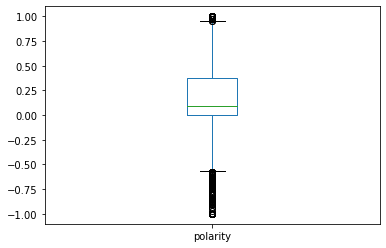

In [74]:
#print box graph of polarities
tweets['polarity'].plot(kind='box')

Interesting. So the graph tells us that many of the outliers in the data are skewed left. This could also be determined since the median is greater than the mean.

Another interesting data point could be seen in his average tweet year, which was 2015.7 (which would be about mid-August that year). We can use the value counts of each year to show the spread:

In [20]:
#print year counts
tweets['year'].value_counts()

2015    4999
2014    2461
2016    2381
2020    1665
2019    1297
2013    1010
2017     945
2012     301
2011     297
2010      18
2009       9
Name: year, dtype: int64

And here is a graph that represents the data:

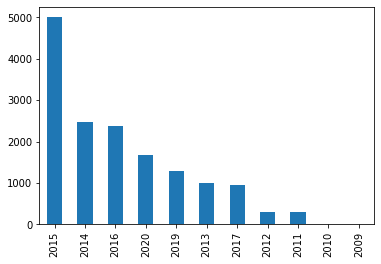

In [21]:
#print bar graph of year counts
tweets['year'].value_counts().plot(kind='bar')

Here we can see that the majority of Trump's twitter volume comes from 2015 with 2014 and 2016 following at a distant second. This makes sense since Trump would've been the most active in spreading his ideas while he was running his first presidential campaign.

Next, we can investigate the averages of his retweets and likes:

In [22]:
#print average retweet count by year
tweets['retweet_count'].groupby(tweets['year']).mean()

year
2009       10.777778
2010      267.833333
2011      141.309764
2012      724.023256
2013      158.161386
2014      141.877692
2015      617.622925
2016     7434.606048
2017    18290.198942
2019    14673.334618
2020    15886.820420
Name: retweet_count, dtype: float64

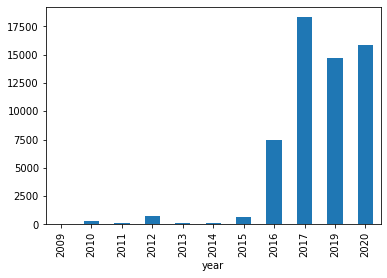

In [23]:
#print bar graph of retweet averages
tweets['retweet_count'].groupby(tweets['year']).mean().plot(kind='bar')

In [24]:
#print average favorites by year
tweets['favorite_count'].groupby(tweets['year']).mean()

year
2009        6.555556
2010      193.833333
2011       38.350168
2012      373.488372
2013      111.052475
2014      163.689557
2015     1289.534107
2016    21184.755145
2017    72192.398942
2019    33588.303007
2020    42351.416216
Name: favorite_count, dtype: float64

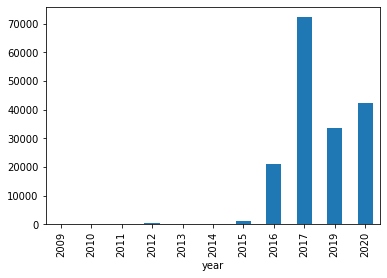

In [25]:
#print bar graph of favorite averages
tweets['favorite_count'].groupby(tweets['year']).mean().plot(kind='bar')

The patterns we see between retweets and favorites over time are quite similar, which is to be expected of course. The data shows that Donald Trump's twitter became much more popular in 2016 (which is probably because it was the election year), but that 2017 was an exceptionally strong year for the growth of his online brand.

## Linguistic Analysis

In [26]:
#print average polarity by year
tweets['polarity'].groupby(tweets['year']).mean()

year
2009    0.348758
2010    0.492695
2011    0.095608
2012    0.111262
2013    0.194547
2014    0.210751
2015    0.214405
2016    0.146285
2017    0.168210
2019    0.092055
2020    0.114950
Name: polarity, dtype: float64

And here is another graph that shows this data:

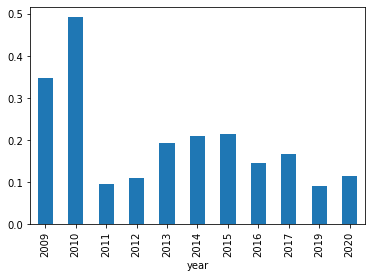

In [27]:
#show bar graph of average polarity
tweets['polarity'].groupby(tweets['year']).mean().plot(kind='bar')

Trump, didn't tweet much in 2009 and 2010, but the graph shows that the tweets he did create had the highest average sentiment values. 2011 and 2012 showed the some rather low sentiment, but after a spike in 2013, his sentiment has been on a rather steady decline.

We can also do the same for the subgroups we made:

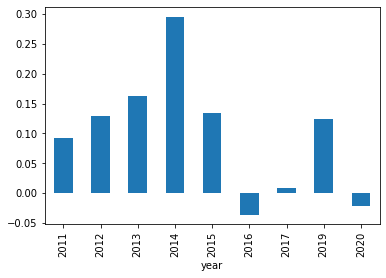

In [28]:
#show bar graph of average polarity for tweets pertaining to russia
tweets[russia]['polarity'].groupby(tweets['year']).mean().plot(kind='bar')

So it seems that Donald Trump began speaking about Russia much more negatively at the start of his election, though 2019 showed a rather large increase. This was probably because of the Mueller Report.

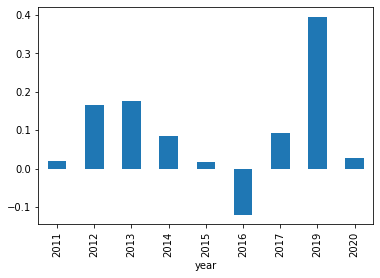

In [29]:
#show bar graph of average polarity for tweets pertaining to iran
tweets[iran]['polarity'].groupby(tweets['year']).mean().plot(kind='bar')

Trump always spoke relatively negatively about Iran, though 2019 was an outlier year. I would guess that 2019 simply did not have enough tweets about Iran to draw a more concrete conclusion, so we can check by seeing how many tweets were made that year:

In [78]:
#print number of tweets by year for iran subset
tweets[iran]['year'].value_counts()

2020    65
2015    64
2013    34
2014    20
2016    20
2011    17
2012    11
2017     9
2019     9
Name: year, dtype: int64

Hmm... nine tweets is certainly not a lot, but it's definitely more than I was expecting. I would suspect that Trump simply didn't have on Iran on his "shitlist" (to put it bluntly) much in 2019, as much of the recent conflict there did not develop until January 2020.

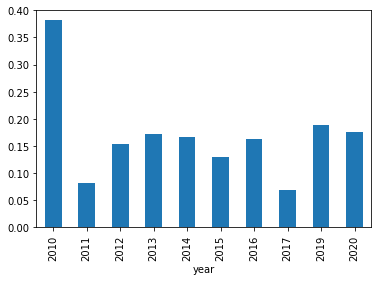

In [33]:
#show bar graph of average polarity for tweets pertaining to north korea
tweets[china]['polarity'].groupby(tweets['year']).mean().plot(kind='bar')

Here we see that Trump has discussed China negatively for most of his Twitter lifespan, with 2010 being an outlier. I would suspect that there was simply not enough data in 2010 to make it such a strong outlier, so let's investigate that:

In [76]:
#print number of tweets by year for china subset
tweets[china]['year'].value_counts()

2015    135
2014     98
2013     77
2016     75
2020     41
2017     40
2012     34
2019     33
2011     28
2010      1
Name: year, dtype: int64

Yes, there is only one tweet from 2010, and so the overall sentiment from that year cannot truely bbe represented.

Overall, I would say that much of this is to be expected, especially considering that Trump aligns himself with many values of the Republican Party. I would say the most shocking discovery can be seen in the chart corresponding to his sentiment towards Russia. Not only does it seem that Trump has flipped on his view towards them several times, the fact that he spoke more positively about them the same year as the Mueller Report came out is very interesting. I've gathered from this that Trump chooses his friends whenever it is of benefit for him, and drops them just as easily when convenient.

## Machine Learning

Up until this point, we have simply explored and analyzed the contents of Trump's tweets and how he felt about certain nations using sentiment analysis. In this section, we will create a machine learning model that guesses whether or not a tweet was composed by Donald Trump. To do this, I will use a Multinomial Naive Bayes and use the dataframe that I created in the Data Processing section of the project. In this case, the tweet contents will be the predictor and the indicator code (T or NT) will be the predicted value.

I'll also make use of a GridSearchCV when making my pipeline. Not only will this allow me to create various folds that will ensure there are some biases within my training and testing splits, but I can test these splits on multiple different parameters within my pipeline.

Because we did this in Homework 4, the following code is adapted from that assignment.

First thing we will do is split the data from our machine learning dataframe into two separate series objects:

In [65]:
#create series from both df columns
text_data = both['text']
code_data = both['code']

Next we will create our pipeline. The pipeline uses a TfidfVectorizer to convert the text into word count representations and then normalize them. It then uses a MultinomialNB as the actual classifier.

In [66]:
#create the model pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')), ('mnb', MultinomialNB())])

Now I will define the parameters that I want the GridSearchCV to test:

In [71]:
#define the parameters
params = {
        'tfidf__max_features' : (1500, 3000, 4500, 9000),
        'mnb__alpha': (1e-2, 1e-3)
        }

I can now create the actual GridSearchCV object with 5 folds and fit it to the data:

In [72]:
#create the GridSearch object
from sklearn.model_selection import GridSearchCV 
search = GridSearchCV(pipe, params, cv=5, n_jobs=-1, return_train_score=True)

#fit the model
search.fit(text_data, code_data)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.5,
                                                        max_features=None,
                                                        min_df=2,
                                                        ngram_range=(1, 1),
                                         

And we can look at the scores with this code:

In [73]:
#view scores
from sklearn.metrics import confusion_matrix, accuracy_score
print("Best Results:")
print("Score:\n", search.best_score_)
print("Parameters:")
for param_name in sorted(params.keys()):
         print("%s: %r" % (param_name, search.best_params_[param_name]))
print("\nAll Results:")
results = pd.DataFrame(search.cv_results_)
print(results[['param_mnb__alpha', 'param_tfidf__max_features', 'mean_test_score']])

Best Results:
Score:
 0.9283317175031696
Parameters:
mnb__alpha: 0.01
tfidf__max_features: 9000

All Results:
  param_mnb__alpha param_tfidf__max_features  mean_test_score
0             0.01                      1500         0.911179
1             0.01                      3000         0.920016
2             0.01                      4500         0.923149
3             0.01                      9000         0.928332
4            0.001                      1500         0.911142
5            0.001                      3000         0.919420
6            0.001                      4500         0.921844
7            0.001                      9000         0.926467


There's a lot of information here, so we can begin our analysis with the best results. A score of about 93% is definitely significant, especially considering our baseline. I've determined that the absolute baseline would be 50% since half of the tweets were from Trump, so if a human were to do this--one who knew absolutely nothing about American politics--they could just guess and expect to be correct half the time.

The GridSearchCV predicted the model with four different tfidf parameters and two different mnb parameters, creating eight instances in total. By looking at the outputs, we can see that the accuracy increased as we increased the maximum number of features, but the accuracy was highest with an MultinomialNB alpha value of 0.01.

## Conclusion
The purpose of this project was to analyze the contents of Donald Trumps Twitter in order to draw conclusions about his tweeting habits and his attitude towards various nations and the stories relating to them. We also used his tweets along with a set of tweets from random users in order to create a machine learning model that predicts whether or not a tweet was composed by Trump.

#### Exploratory Analysis
In this section, we determined that Donald Trump's twitter influence and activity has been growing ever since he joined the platform. In terms of retweets and favorites, Trump's twitter influence increased drastically around the start of his election campaign, and the amount he tweeted also reflects this. I think the most important conclusion here was the stark contrast in the polarity of his tweets, or in other words, the number of outliers that were present. This indicates that Trump uses strong language to both endorse and condemn things.

#### Linguistic Analysis
In this section, we used sentiment analysis to determine how positively or negatively Trump spoke about three different nations: Russia, Iran, and China. While most of this was expected, the bar graph corresponding to Russia was the most shocking. Donald Trump seemed to be taking the side of Russia up until his election campaign began, then his sentiment completely flipped in the span of a year. Additionally, the drastic increase in 2019 shows that Trump spoke more highly of Russia, which was conventiently during the same time as the Mueller Report... The biggest takeaway here is that Trump seems to use his Twitter influence and strong language to attack his foes and endorse his friends.

#### Machine Learning
Of all the sections in the project, I felt that this one yielded the most conclusive results. While the others could indicate a myriad of factors at play, this section showed that Trump has a very unique style of Tweeting. My original plan was to compare his Tweets to a single other person's such as Barack Obama or Hillary Clinton, I think being able to pick his tweets out of a larger crowd is much more interesting. While this could probably be done with many people to some degree--everyone has their own style of tweeting and preferred topics to tweet about--an accuracy of 93% is nonetheless quite significant.

#### Final Thoughts
The most important thing to take away from this project is that politicians have a lot of online influence, and they use this influence to persuade their followers to behave in a certain way. For the rest of us, when we send a tweet, we are not directly affecting anybody. For someone like Trump who is in a powerful political position, what he says and does on Twitter can have a tangible impact on Americans. It is important for us to be aware of this influence and always check those who are in power, because no matter who you are, we are all subject to the 240 character limit.